# Exploring regularization through shrinkage methods (Ridge Regression and LASSO)

In this activity you will explore using L2 and L1 Regularization to see how they affect both performace of the regression model (MSE) and how they influence change the coefficient values in the model.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Helper Functions 

## (INSTRUCTOR PROVIDED CODE)

Note:  we do not use `sklearn sklearn.preprocessing.PolynomialFeatures` because it would also potentially create interaction terms if there was more than one feature... we only want polynomials on the original features for this activity

In [2]:
def makeDataQuadratic(myseed,mysize=200):
    np.random.seed(myseed)   #dont forget to import numpy as np
    #y = np.zeros(shape = 100) #100  0-1 normal floats
    x = np.random.normal(size=mysize) #100  0-1 normal floats
    y = 2*(x**2)+np.random.normal(size = x.shape)
    df = pd.DataFrame({'x':x, 'y':y}) #dont forget to import pandas as pd
    return(df) 


def polyDesignMatrix(x, p):
    #print(np.arange(p+1))  #arange from 0 to desired model order size
    xarray = np.array((x)).reshape(-1,1)  #enforces this to be a matrix
    X = np.power(xarray, np.arange(p+1))
    return(X)

#default figure sizes for matplotlib plots
myfigsize=(16,9)


# Generate Design Matrix of order 3

## (INSTRUCTOR PROVIDED CODE)



In [3]:
myseed = 1
modelOrder = 3  #Cubic model with design matrix: 1, x, x^2, x^3
df = makeDataQuadratic(myseed)

polyX = polyDesignMatrix(df['x'],modelOrder)
print("Design Matrix Shape: ",polyX.shape)

Design Matrix Shape:  (200, 4)


# STEP 1: Create train and validations sets

## (STUDENT CODING REQUIRED)


Task: create training and validation sets using `train_test_split`  (already imported from `sklearn.model_selection`)

(Even though these directions are long, this should be ~1 line of code)

Ref the `test_train_split` API here:  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Notice that `test_train_split` is just a data and label splitter... it doesnt know what you will do with the data later - so it can be used to generate a validation set just as easilty as generating a test set.  For this exercise, we wont be using a test set... just a training and a vailidation set.

You will need to provide the following for the `train_test_split` function:
* the design matrix of features `polyX` (with shape= `(200,4)` )
* the vector of target variabes (y) which can be directly obtained using `df['y']`.  `df['y']` yields a vector of shape `(200,)`
* the amount of data to be used for the validation set, as a fraction of the total amount of data (provided for you in the variable `valset_fraction`)
* the value for `random_state` (provided for you in the variable `myrandom_state`)

`train_test_split` will return a series of four items (matrices for X, vectors for y) which you will store into the variables: `trainX, valX, trainy, valy`

Assuming 200 observations and a design matrix of 4 columns, confirm that the shapes of `trainX, valX, trainy, valy` match these outputs:
```
Shapes:  (100, 4) (100, 4) (100,) (100,)
```

In [4]:
myrandom_state = 42   #set for reproducability
valset_fraction = 0.5

trainX, valX, trainy, valy = [], [], [], []  #temporary variables that need to be filled from train_test_split

#--------------- START STUDENT CODE --------------------------------

trainX, valX, trainy, valy = train_test_split(polyX, df['y'], test_size=valset_fraction, random_state=myrandom_state)

#---------------- END STUDENT CODE --------------------------------

print("Shapes: ", trainX.shape, valX.shape, trainy.shape, valy.shape)
# should return "Shapes:  (100, 4) (100, 4) (100,) (100,)"

Shapes:  (100, 4) (100, 4) (100,) (100,)


# STEP 2: Create Grid of Alphas for regularization penalties on models

## (STUDENT CODING REQUIRED)


Task: Use `np.logspace` to generate log-spaced values between `minLogAlpha` and `maxLogAlpha` and store them in `alphagrid`.  The quantity of alphas to be created is the value of `alphaCount`

(about ~1 line of code)

Using logspace is important when setting parameters for regularization because we want to explore a large range of possible parameters,
but if we cover them linearly, then very few of them will be explored in the low range and the granularity will be large 


The instructor-provided code below sets a minimum and maximum log(alpha) value for base-10 exponents from -3 to 7 (0.001 to 10,000,000).  

Verify your output of the print statement at the end of the code is 
```
Min and Max Alpha:  0.001 10000000.0
Smallest Granularity and Largest Granularity: 2.331657833024481e-05 ;  227853.0302742757
```



In [5]:
minLogAlpha = -3
maxLogAlpha = 7
alphaCount = 1000

alphagrid = np.zeros(alphaCount)  # placeholder for the alphas

#------------- START STUDENT CODE ------------------

alphagrid = np.logspace(minLogAlpha,maxLogAlpha,num=alphaCount)

#------------- END STUDENT CODE -------------------

#confirm the values below range from 0.001 to 10M and the granularity at the low end is order 2.3e-5 and on thigh end is around ~228K
print("Min and Max Alpha: ", np.min(alphagrid),np.max(alphagrid))
dAlphagrid = np.diff(alphagrid)
print("Smallest Granularity and Largest Granularity:", np.min(dAlphagrid),"; ", np.max(dAlphagrid))

#APPROXIMATE EXPECTED OUTPUT:
"""
Min and Max Alpha:  0.001 10000000.0
Smallest Granularity and Largest Granularity: 2.331657833024481e-05 ;  227853.0302742757
"""

Min and Max Alpha:  0.001 10000000.0
Smallest Granularity and Largest Granularity: 2.331657833024481e-05 ;  227853.0302742757


'\nMin and Max Alpha:  0.001 10000000.0\nSmallest Granularity and Largest Granularity: 2.331657833024481e-05 ;  227853.0302742757\n'

# STEP 3 : Create ridge regression model and collect model coefficients and MSEs at the alphas

## (STUDENT CODING REQUIRED)


Task: Use `sklearn.linear_model.Ridge` model to train a ridge regression and collect the coefficients and val-set MSE of the model at each value of alpha 

Review this page for details on the Ridge model API https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

The code below instantiates a Ridge Regression model (`mymodelR`) for you, but you still need to train and evaluate the model at various alphas.  
You goal is to fill the variables `ridgeCoeffs` and `ridgeMSEs` with the appropriate information in order to build graphs in the later steps.

you will need 
* training data (`trainX` and `trainY`) in order to fit the model 
* validation data (`valX`) in order to make predictions which will be stored in `preds`
* `mean_squared_error` to find the errors between the predictions and `valy` on the valset (note this has already been imported (from `sklearn.metrics`) 
* `linear_model.Ridge` , with `myalpha` and `fit_intercept=False` since we are passing a design matrix in for the data
* `.fit`, `.predict`, and  `.coef_` from the model accessors 

Carefully follow the comments in the student code section to create each of the requried four lines of code.
        


In [6]:
ridgeCoeffs = np.zeros((len(alphagrid),modelOrder+1))
ridgeMSEs = np.zeros(len(alphagrid))


i = 0
for i, myalpha in enumerate(alphagrid):
    mymodelR = linear_model.Ridge(alpha = myalpha, fit_intercept=False)
    preds = np.zeros(valy.shape) #temp holder for model predictions at this alpha value
    
    #--------------- START STUDENT CODE --------------------------------


    # FIT THE MODEL to the training data using the .fit function with `trainX` and `trainY`
    mymodelR.fit(trainX,trainy)

    # Make predictions on valX and store them in `preds`
    preds = mymodelR.predict(valX)

    # Find the scalar MSE of the predictions (`preds`) on valy and store it at the location ridgeMSEs[i]
    ridgeMSEs[i] = mean_squared_error(preds,valy)

    # from the Ridge model, obtain the vector of coefficents (1 per member of the design matrix val from x^0 (=1) through x^modelOrder) 
    # Get the vector from the model by using lthe .coef_ accessor and then store the coefficient vector in ridgeCoeffs[i,:]
    ridgeCoeffs[i,:] = mymodelR.coef_
    
    #--------------- END STUDENT CODE --------------------------------

    
# uncomment the lines below if you want to see the printouts    
# print()
# print(ridgeCoeffs)
# print(ridgeMSEs)


# Plot coefficencts of ridge model as function of alphas

## (INSTRUCTOR PROVIDED CODE)



First we plot Ridge parameter alpha (log scale) versus the beta coefficients of the resulting model

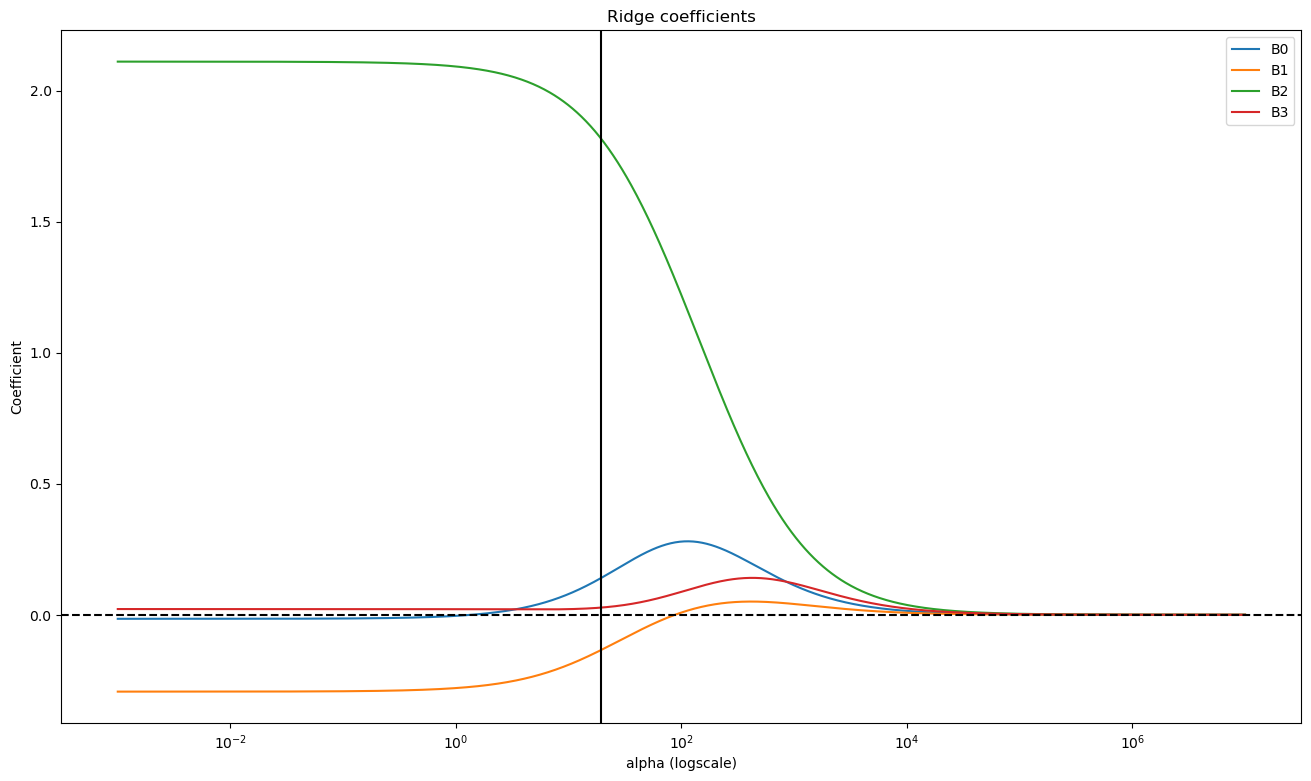

In [7]:
minRidgeMSEindeces = np.argmin(ridgeMSEs)
minRidgeMSE = ridgeMSEs[minRidgeMSEindeces]
minRidgeAlpha = alphagrid[minRidgeMSEindeces]

plt.figure(figsize=myfigsize)
plt.semilogx(alphagrid,ridgeCoeffs[:,0:modelOrder+1])
plt.legend(["B0","B1","B2","B3"])
plt.title("Ridge coefficients")
plt.axhline(linestyle = '--', color='k')
plt.axvline(x=minRidgeAlpha, color='k')
plt.xlabel('alpha (logscale)')
plt.ylabel('Coefficient')
plt.show()



In order to see the interesting portion of the graph better we can "zoom in" on the alpha range of interest

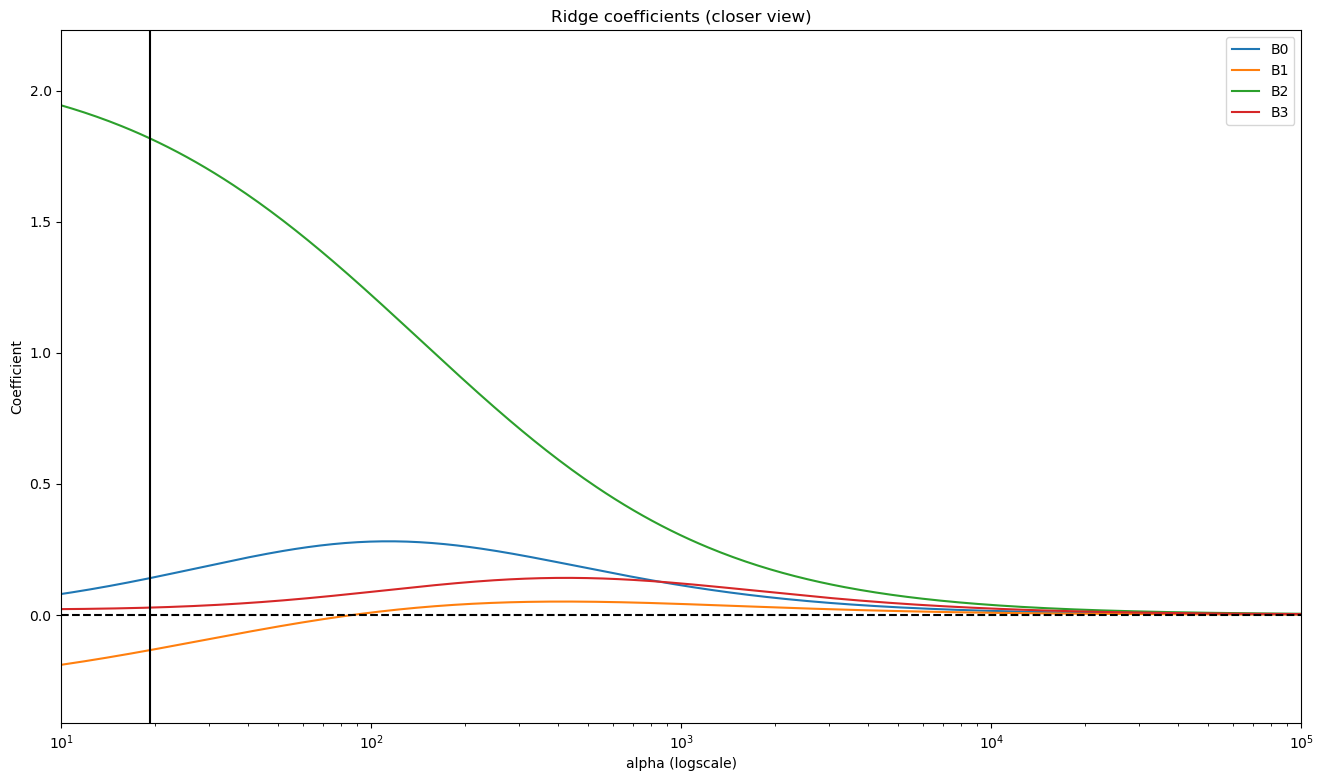

In [8]:
minRidgeMSEindeces = np.argmin(ridgeMSEs)
minRidgeMSE = ridgeMSEs[minRidgeMSEindeces]
minRidgeAlpha = alphagrid[minRidgeMSEindeces]

plt.figure(figsize=myfigsize)

plt.semilogx(alphagrid,ridgeCoeffs[:,0:modelOrder+1])
plt.xlim(10,100000)
plt.legend(["B0","B1","B2","B3"])
plt.title("Ridge coefficients (closer view)")
plt.axhline(linestyle = '--', color='k')
plt.axvline(x=minRidgeAlpha, color='k')
plt.xlabel('alpha (logscale)')
plt.ylabel('Coefficient')
plt.show()



By displaying the absolute value of the coeffiecients on the vertical axis using a log scale we can get a better feel for their relative magnitudes.
Notice that as the model fit changes, the relative magnitude values of the coefficients can change and even the relative rank ordering of the magnitudes can change.

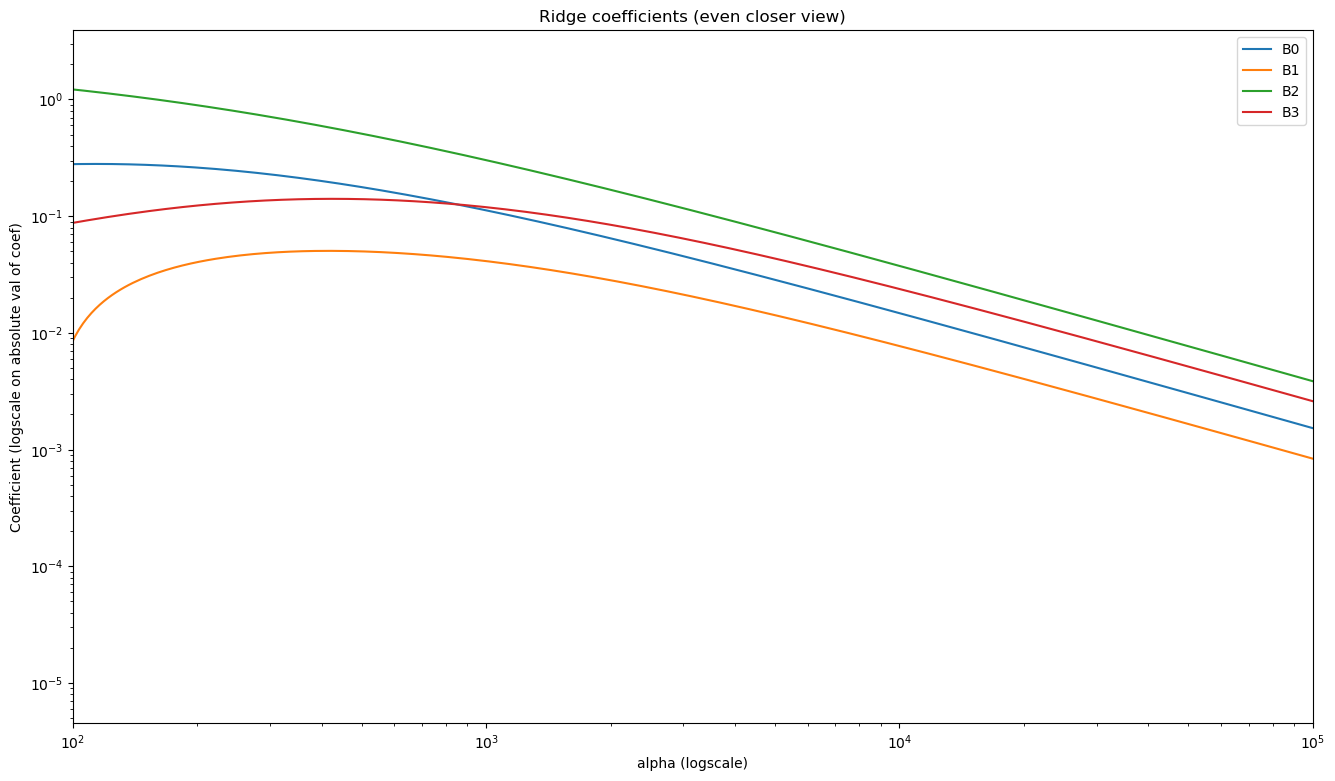

In [9]:
plt.figure(figsize=myfigsize)


plt.loglog(alphagrid,np.abs(ridgeCoeffs[:,0:modelOrder+1]))
plt.xlim(100,100000)
plt.legend(["B0","B1","B2","B3"])
plt.title("Ridge coefficients (even closer view)")
plt.axhline(linestyle = '--', color='k')
plt.axvline(x=minRidgeAlpha, color='k')
plt.xlabel('alpha (logscale)')
plt.ylabel('Coefficient (logscale on absolute val of coef)')
plt.show()



# For Ridge, plot alphs vs. MSE on predictions of the validation set

## (INSTRUCTOR PROVIDED CODE)



Here we display a graph of validation set error resulting from various values of alpha (log scale)

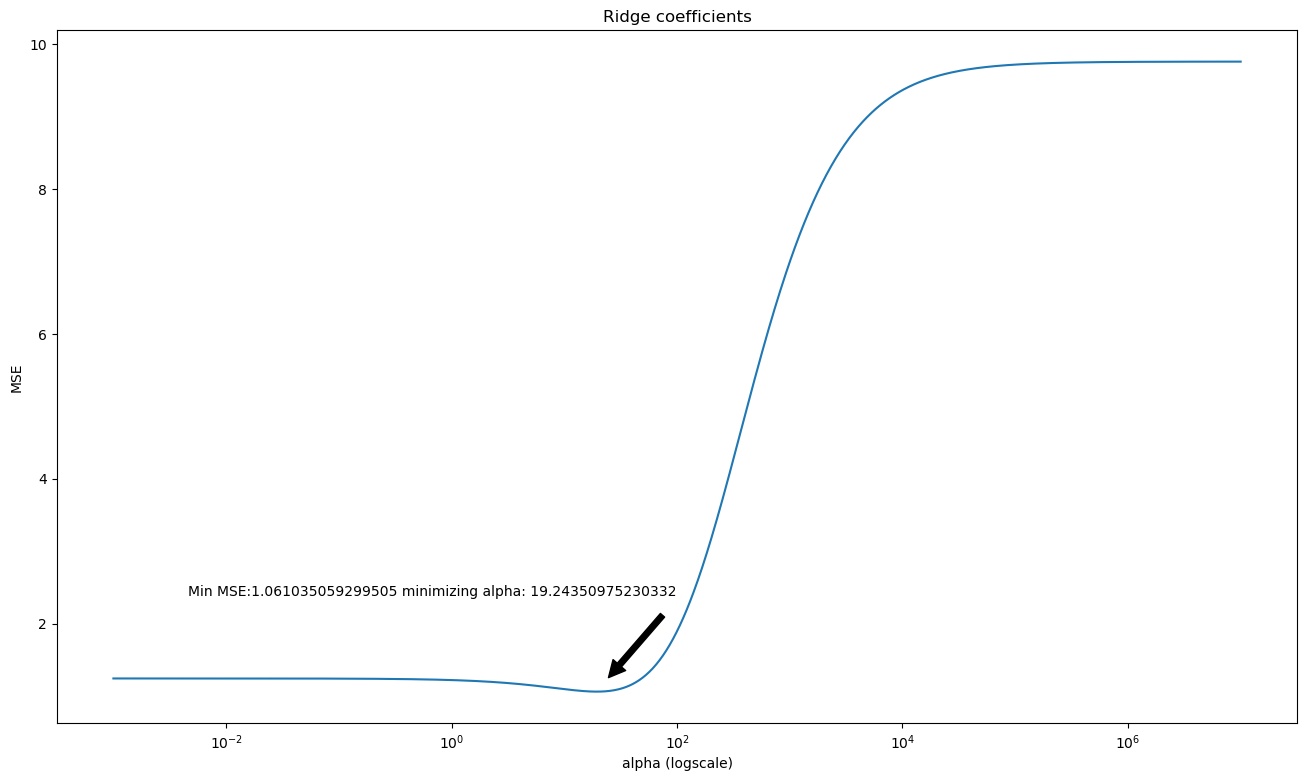

In [10]:

plt.figure(figsize=myfigsize)


plt.semilogx(alphagrid,ridgeMSEs[:])
#plt.legend(["MSE"])
plt.title("Ridge coefficients")
plt.annotate('Min MSE:'+ str(minRidgeMSE) + ' minimizing alpha: '+ str(minRidgeAlpha) ,
            xy=(minRidgeAlpha, minRidgeMSE), xycoords='data',
            xytext=(0.5, 0.2), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.15),
            horizontalalignment='right', verticalalignment='top')
plt.xlabel('alpha (logscale)')
plt.ylabel('MSE')
plt.show()

By plotting MSE on a log scale as well, we can see the minimum MSE easier.

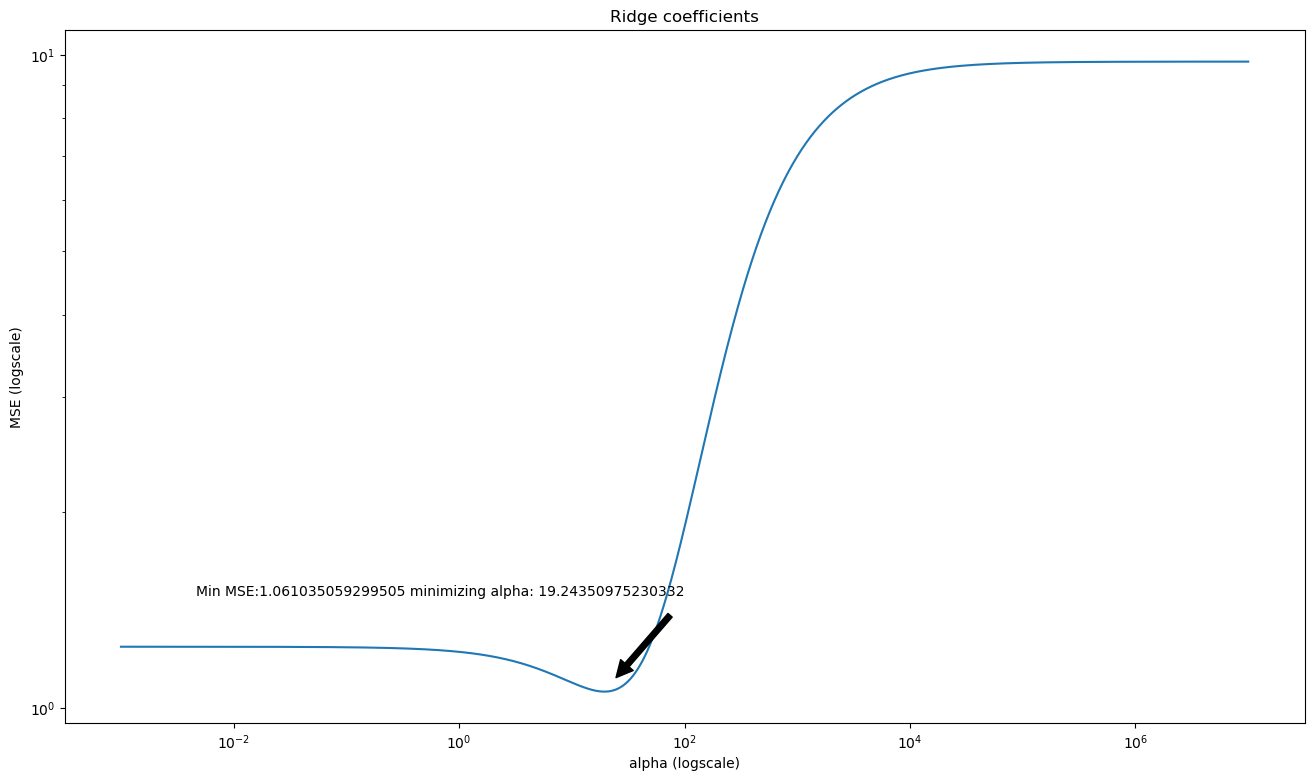

In [11]:

plt.figure(figsize=myfigsize)


plt.loglog(alphagrid,ridgeMSEs[:])
#plt.legend(["MSE"])
plt.title("Ridge coefficients")
plt.annotate('Min MSE:'+ str(minRidgeMSE) + ' minimizing alpha: '+ str(minRidgeAlpha) ,
            xy=(minRidgeAlpha, minRidgeMSE), xycoords='data',
            xytext=(0.5, 0.2), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.15),
            horizontalalignment='right', verticalalignment='top')
plt.xlabel('alpha (logscale)')
plt.ylabel('MSE (logscale)')
plt.show()

# STEP 4: Create LASSO regression model and display coefficients

## (STUDENT CODING REQUIRED)


Task: Use sklearn.linear_model.Lasso to train a LASSO and collect the coefficients and val-set MSE of the model at each value of alpha 

(The instructions below are shortened explanations of the activity from Ridge Regression (step 6); the steps should be the same BUT the variables being filled have different names (`lassoCoeffs` and `lassoMSEs`) - *beware of this if you cut and paste your code from earlier*)

Review this page for details on the LASSO model API https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

you will need 
* training data (`trainX` and `trainY`) in order to fit the model
* validation data (`valX`) in order to make predictions
* `mean_squared_error` to find the errors between the predictions and `valy` on the valset (note this has already been imported (from `sklearn.metrics`) 
* `linear_model.Lasso` , with `myalpha` and `fit_intercept=False` since we are passing a design matrix in for the data
* `.fit`, `.predict`, and  `.coef_` from the model accessors 

Carefully follow the comments in the student code section to create each of the requried four lines of code

In [12]:
lassoCoeffs = np.zeros((len(alphagrid),modelOrder+1))  #first dim is the alpha value index, second dim is the coefficient value index for the model order
lassoMSEs = np.zeros(len(alphagrid))  #indexed by alpha value index

i = 0
for i, myalpha in enumerate(alphagrid):  #index over possible alpha values for LASSO
    
    # Generate a model for Lasso using the desired current alpha (note that this doesnt fit the model to any data yet)
    mymodelL = linear_model.Lasso(alpha = myalpha, fit_intercept=False)
    
    #--------------- START STUDENT CODE --------------------------------

    # FIT THE MODEL to the training data
    mymodelL.fit(trainX,trainy)
    
    # Make predictions on valX
    preds = mymodelL.predict(valX)
    
    # Find the MSE of the predictions on valy
    lassoMSEs[i] = mean_squared_error(preds,valy)
    
    # Obtain the coefficents from the lasso model using .coef_
    lassoCoeffs[i,:] = mymodelL.coef_
    
    #--------------- END STUDENT CODE --------------------------------


# Uncomment the lines below to print out the coefficients and MSEs from LASSO    
#print()
#print(lassoCoeffs)
#print(lassoMSEs)

# Plot coefficients of LASSO as a function of alpha value & describe coefficients behavior 

## (INSTRUCTOR-PROVIDED CODE)

First we look at the graph of a wide range of alphas (log scaled axis) vs LASSO-regularized coefficient

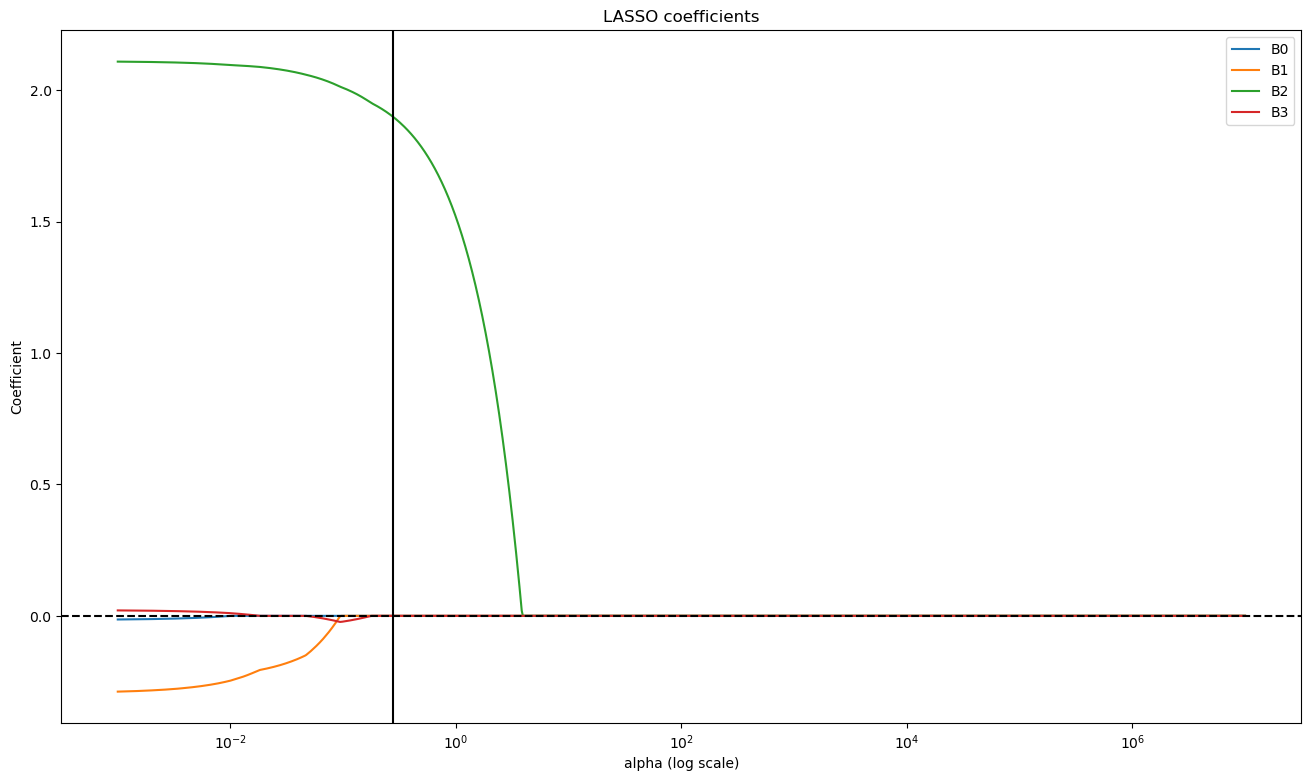

In [13]:
minlassoMSEindeces = np.argmin(lassoMSEs)
minlassoMSE = lassoMSEs[minlassoMSEindeces]
minlassoAlpha = alphagrid[minlassoMSEindeces]


plt.figure(figsize=myfigsize)

plt.semilogx(alphagrid,lassoCoeffs[:,0:modelOrder+1])
plt.legend(["B0","B1","B2","B3"])
plt.title("LASSO coefficients")
plt.axhline(linestyle = '--', color='k')
plt.axvline(x=minlassoAlpha, color='k')
plt.xlabel('alpha (log scale)')
plt.ylabel('Coefficient')
plt.show()

Next we look at the graph of a wide range of alphas (log scaled axis) vs Log of the LASSO-regularized coefficient

This allows us to see the quick dropoff as LASSO pushes coefficients rapidly to zero (though zero cannot be shown on a log scale)

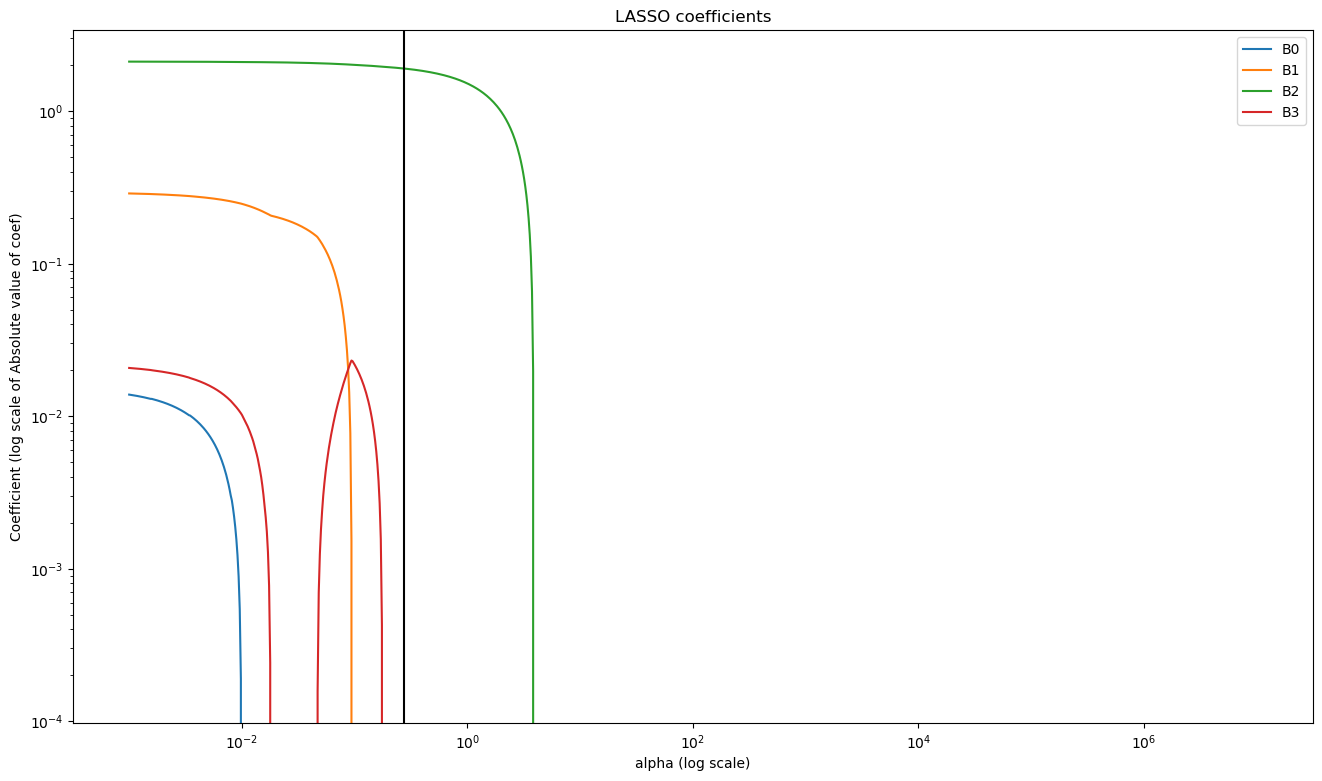

In [14]:
plt.figure(figsize=myfigsize)

plt.loglog(alphagrid,np.abs(lassoCoeffs[:,0:modelOrder+1]))
plt.legend(["B0","B1","B2","B3"])
plt.title("LASSO coefficients")
plt.axhline(linestyle = '--', color='k')
plt.axvline(x=minlassoAlpha, color='k')
plt.xlabel('alpha (log scale)')
plt.ylabel('Coefficient (log scale of Absolute value of coef)')
plt.show()

# For LASSO, plot alphas vs. MSE on predictions of the validation set

## (INSTRUCTOR-PROVIDED CODE)

In the graph below, we examine the effect of LASSO parameter alpha (log scale) versus the MSE of the model fit

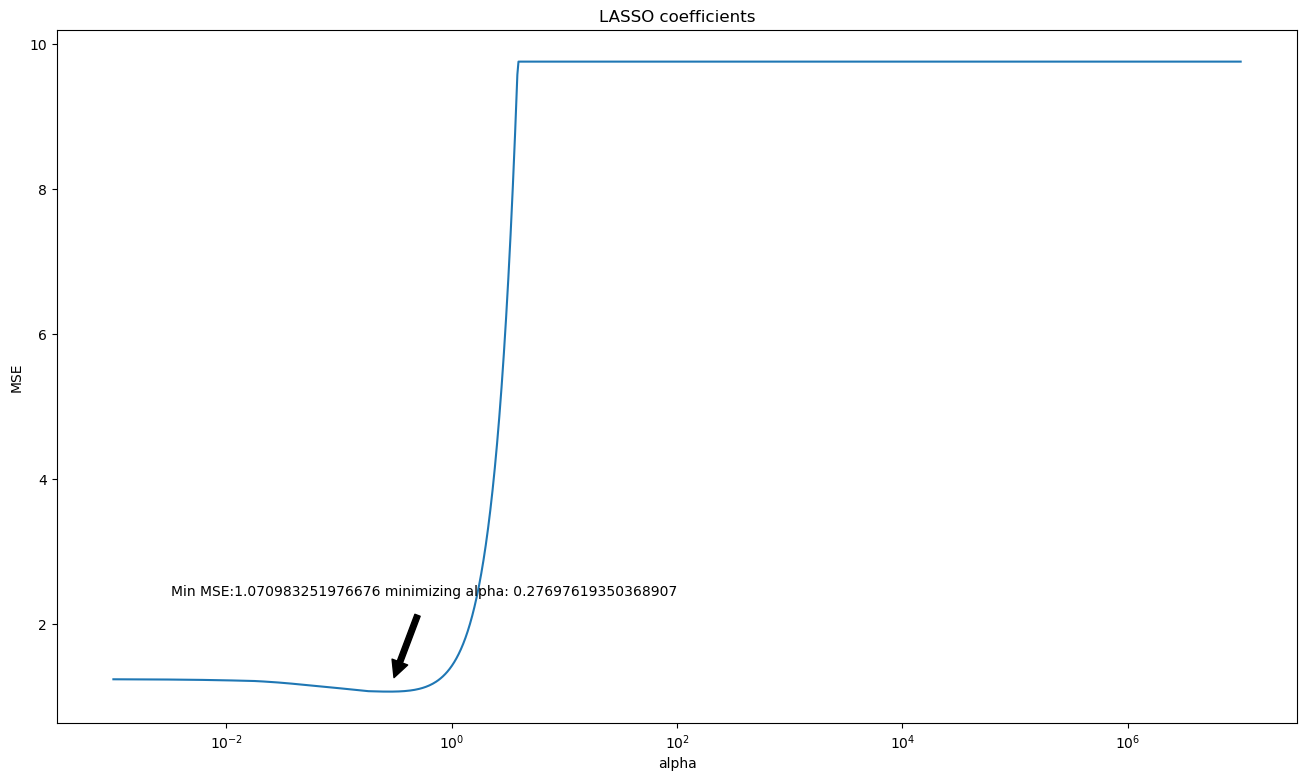

In [15]:


plt.figure(figsize=myfigsize)

plt.semilogx(alphagrid,lassoMSEs[:])
#plt.legend(["MSE"])
plt.title("LASSO coefficients")
plt.annotate('Min MSE:'+ str(minlassoMSE) + ' minimizing alpha: '+ str(minlassoAlpha) ,
            xy=(minlassoAlpha, minlassoMSE), xycoords='data',
            xytext=(0.5, 0.2), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.15),
            horizontalalignment='right', verticalalignment='top')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.show()

In the graph below, we examine the effect of LASSO parameter alpha (log scale) versus the MSE of the model fit (also log scale).  In this graph, the minimizing MSE is slightly easier to locate visually

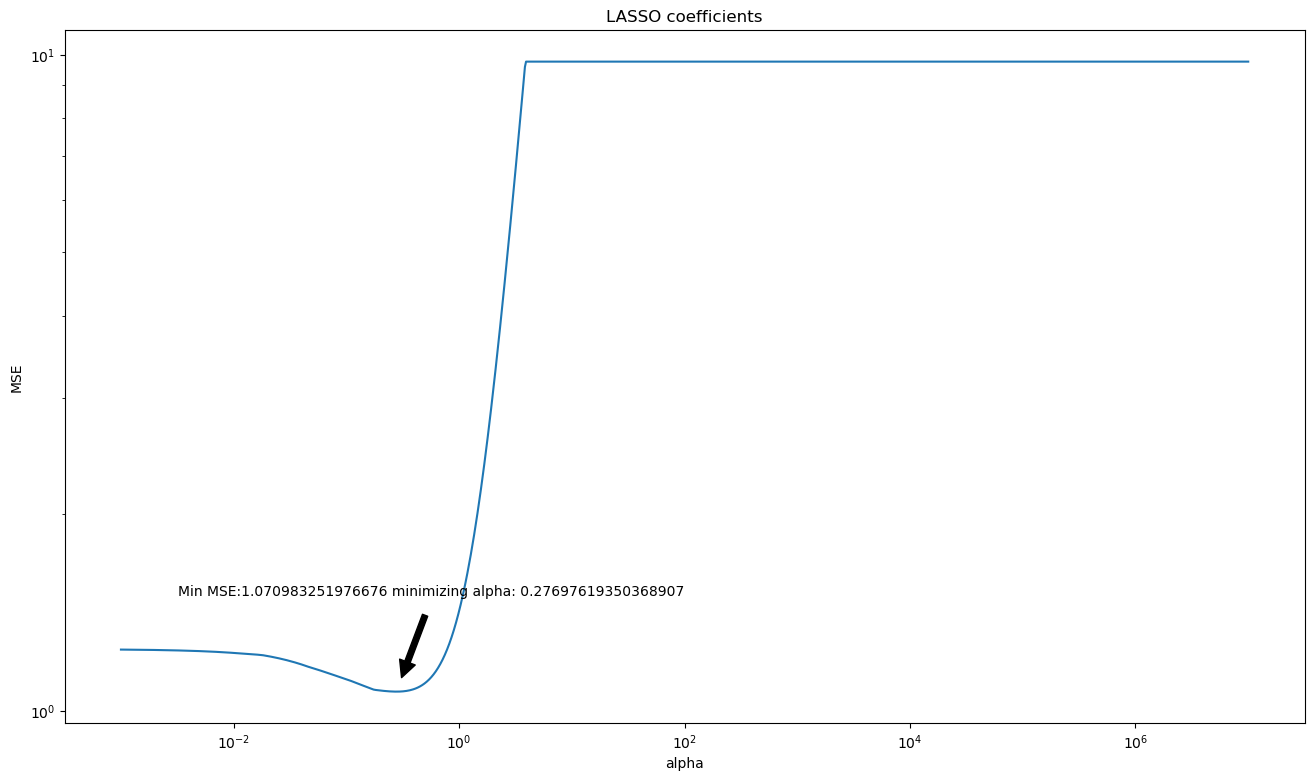

In [16]:


plt.figure(figsize=myfigsize)

plt.loglog(alphagrid,lassoMSEs[:])
#plt.legend(["MSE"])
plt.title("LASSO coefficients")
plt.annotate('Min MSE:'+ str(minlassoMSE) + ' minimizing alpha: '+ str(minlassoAlpha) ,
            xy=(minlassoAlpha, minlassoMSE), xycoords='data',
            xytext=(0.5, 0.2), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.15),
            horizontalalignment='right', verticalalignment='top')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.show()

# Use validation set to determine best ridge and lasso values for data

## (INSTRUCTOR-PROVIDED CODE)

In [17]:
if minRidgeMSE < minlassoMSE:
    print("Ridge Model is the best model - at alpha ", minRidgeAlpha, " MSE = ", minRidgeMSE)
else:
    print("LASSO Model is the best model - at alpha ", minlassoAlpha, " MSE = ", minlassoMSE)
    
    


Ridge Model is the best model - at alpha  19.24350975230332  MSE =  1.061035059299505
